In [1]:
import pathlib
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import pyproj
import xrft
import verde as vd
import harmonica as hm

import euler

In [2]:
data_dir = pathlib.Path("..") / "data"
data_path = data_dir / "1038_XYZ.tar.xz"
with tarfile.open(data_path) as archive:
    with archive.extractfile("1038_XYZ/1038/spaulo_rjaneiro_rj.xyz") as data_file:
        raw_data = []
        usecols = [2, 3, 4, 18]        
        read_data = False
        for i, line in enumerate(data_file):
            line = line.decode("latin1")
            if i < 5:
                continue
            if line.strip().startswith("LINE"):
                line_no = int(line.strip().split()[-1][:-1])
                read_data = True
                continue
            # Skip the tie lines because some of them are bad
            if line.strip().startswith("TIE"):
                read_data = False
                continue
            if read_data:
                columns = [float(c.strip()) for c in line.strip().split()]
                raw_data.append([columns[c] for c in usecols] + [line_no])
    full_data = pd.DataFrame(
        raw_data,
        columns=[
            "longitude", 
            "latitude", 
            "total_field_anomaly_nT", 
            "altitude_m",
            "line_number",
        ],
    )
region = [-42.64, -41.9, -22.6, -22]
data = full_data.loc[vd.inside((full_data.longitude, full_data.latitude), region)].reset_index(drop=True).copy()
data

,longitude,latitude,total_field_anomaly_nT,altitude_m,line_number
0,-42.639984,-22.290527,-16.56,151.49,2800
1,-42.639969,-22.291397,-43.47,162.46,2800
2,-42.639954,-22.292267,-65.38,170.69,2800
3,-42.639938,-22.293152,-74.29,173.43,2800
4,-42.639923,-22.294022,-67.20,170.08,2800
...,...,...,...,...,...
50877,-41.905685,-22.497009,163.33,143.87,4600
50878,-41.905685,-22.497879,175.29,142.34,4600
50879,-41.905701,-22.498734,180.25,140.51,4600
50880,-41.905701,-22.499588,175.21,138.68,4600


In [3]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
data = data.assign(**{
    name: coord 
    for name, coord in zip(
        ["easting_m", "northing_m"], projection(data.longitude, data.latitude)
    )
})

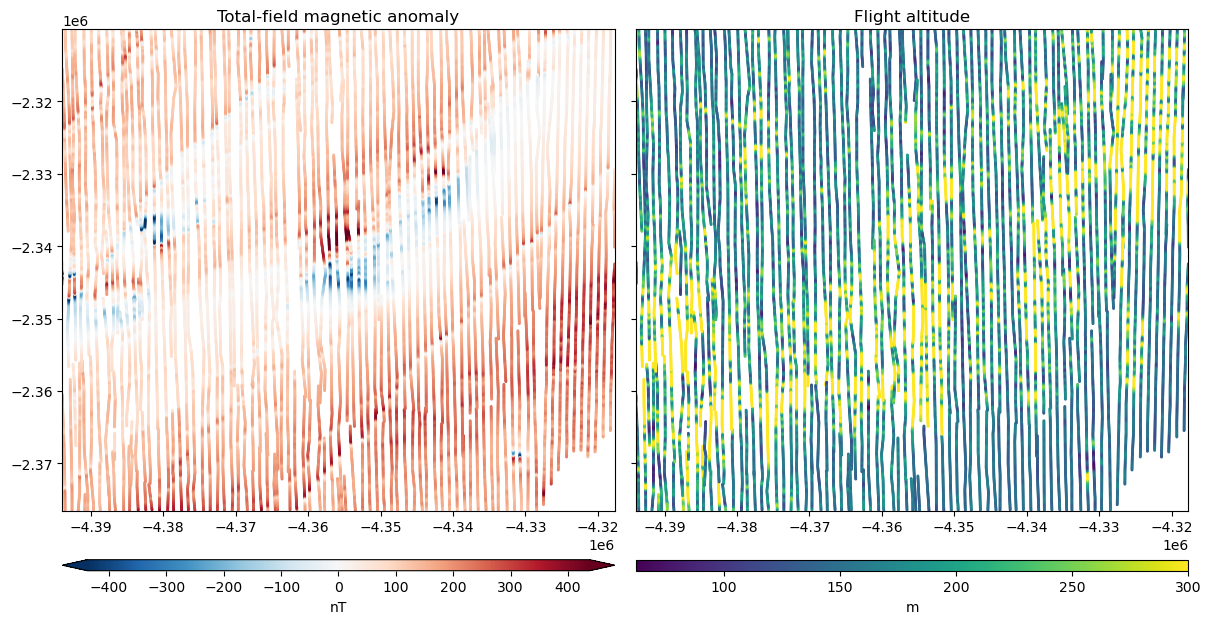

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7), sharey=True, layout="constrained")
for ax in axes:
    ax.set_aspect("equal")
    ax.set_xlim(data.easting_m.min(), data.easting_m.max())
    ax.set_ylim(data.northing_m.min(), data.northing_m.max())
ax = axes[0]
ax.set_title("Total-field magnetic anomaly")
scale = 0.5 * vd.maxabs(data.total_field_anomaly_nT)
tmp = ax.scatter(
    data.easting_m, 
    data.northing_m, 
    s=1, 
    c=data.total_field_anomaly_nT, 
    cmap="RdBu_r",
    vmin=-scale,
    vmax=scale,
)
cb_kwargs = dict(aspect=50, pad=0.01, orientation="horizontal")
fig.colorbar(tmp, ax=ax, label="nT", extend="both", **cb_kwargs)
ax = axes[1]
ax.set_title("Flight altitude")
tmp = ax.scatter(
    data.easting_m, 
    data.northing_m, 
    s=1, 
    c=data.altitude_m, 
    cmap="viridis",
)
fig.colorbar(tmp, ax=ax, label="m", **cb_kwargs)
plt.show()

In [5]:
%%time
spacing = 250
region_proj = vd.get_region((data.easting_m, data.northing_m))
eqs = hm.EquivalentSourcesGB(damping=1e1, depth=1000, block_size=spacing, random_state=42)
coordinates = (data.easting_m, data.northing_m, data.altitude_m)
eqs.fit(coordinates, data.total_field_anomaly_nT)

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/harmonica/_equivalent_sources/gradient_boosted.py:224: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  data = data.ravel()
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x73eda43b5580> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x73eda43b5580> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable

CPU times: user 2min 14s, sys: 3.55 s, total: 2min 17s
Wall time: 22.3 s


EquivalentSourcesGB(block_size=250, damping=10.0, depth=1000, random_state=42)

In [6]:
delta = 5
data["deriv_up"] = (
    eqs.predict((data.easting_m, data.northing_m, data.altitude_m + delta))
    - eqs.predict((data.easting_m, data.northing_m, data.altitude_m - delta))
) / (2 * delta)
data["deriv_east"] = (
    eqs.predict((data.easting_m + delta, data.northing_m, data.altitude_m))
    - eqs.predict((data.easting_m - delta, data.northing_m, data.altitude_m))
) / (2 * delta)
data["deriv_north"] = (
    eqs.predict((data.easting_m, data.northing_m + delta, data.altitude_m))
    - eqs.predict((data.easting_m, data.northing_m - delta, data.altitude_m))
) / (2 * delta)

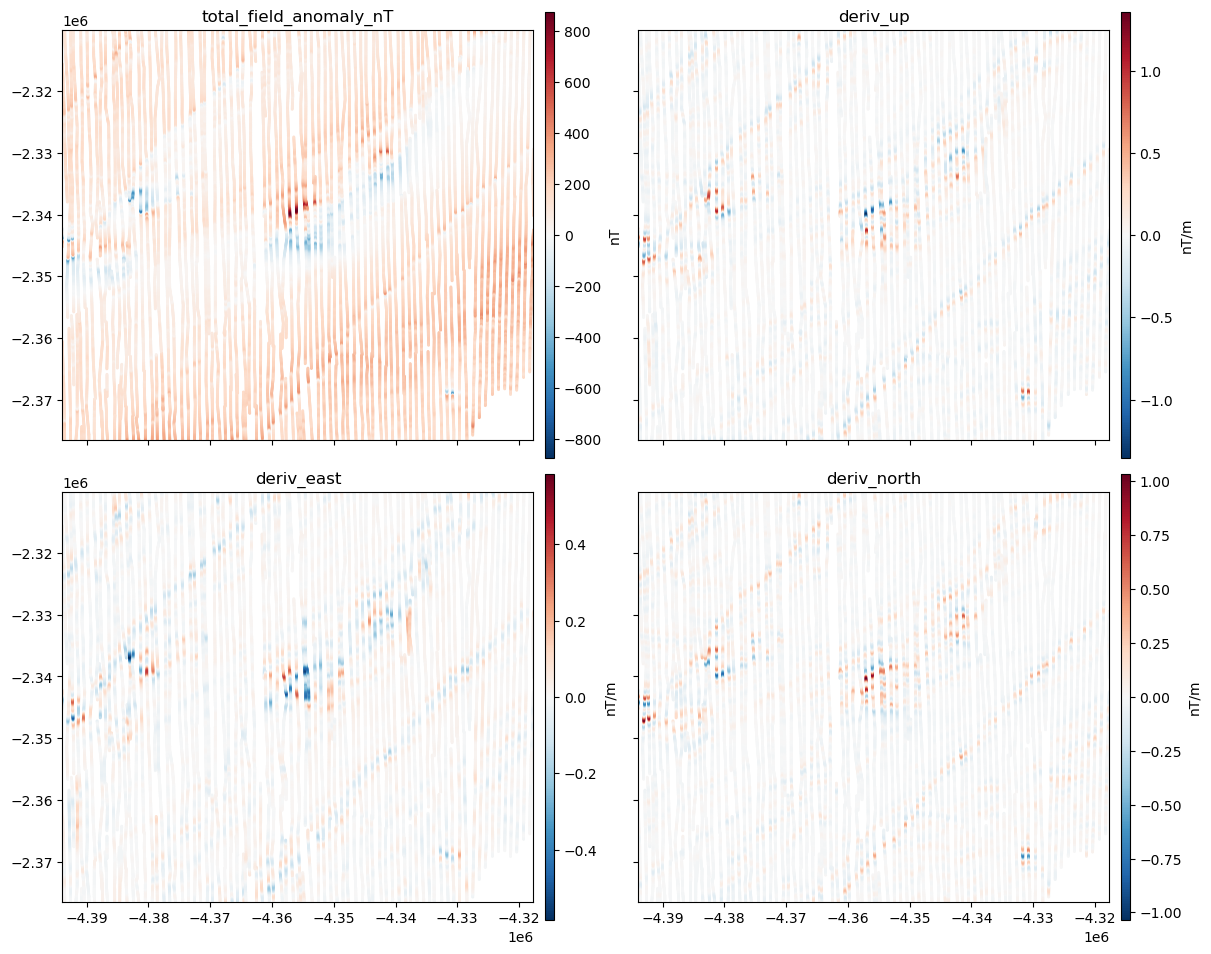

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9.5), sharex=True, sharey=True, layout="constrained")
for ax in axes.ravel():
    ax.set_aspect("equal")
    ax.set_xlim(data.easting_m.min(), data.easting_m.max())
    ax.set_ylim(data.northing_m.min(), data.northing_m.max())

variables = [
    "total_field_anomaly_nT",
    "deriv_up",
    "deriv_east",
    "deriv_north",
]
units = ["nT", "nT/m", "nT/m", "nT/m"]
for ax, var, unit in zip(axes.ravel(), variables, units):
    scale = vd.maxabs(data[var])
    ax.set_title(var)
    tmp = ax.scatter(data.easting_m, data.northing_m, s=1, c=data[var], vmin=-scale, vmax=scale, cmap="RdBu_r")
    fig.colorbar(tmp, ax=ax, label=unit, aspect=50, pad=0.01, orientation="vertical")
plt.show()

In [ ]:
%%time
window_size = 10e3
window_step = window_size / 10
ei = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.1,
).fit(
    coordinates=(data.easting_m.values, data.northing_m.values, data.altitude_m.values), 
    data=(data.total_field_anomaly_nT.values, data.deriv_east.values, data.deriv_north.values, data.deriv_up.values),
)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), layout="constrained")
scale = np.percentile(np.abs(data.total_field_anomaly_nT), 99.9)
block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter((data.easting_m, data.northing_m), data.total_field_anomaly_nT)
ax.scatter(*block_coords, s=20, c=block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r")
ax.set_aspect("equal")
markers = ["v", "^", "o"]
labels = {}
size = 50
vmin, vmax = -2500, 0
for si, marker in zip([1, 2, 3], markers):
    is_si = ei.structural_indices_ == si
    tmp = ax.scatter(
        *ei.locations_[:2, is_si],
        c=ei.locations_[2, is_si],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        cmap="tab20b",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)
ax.legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=ax,
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)
ax.add_artist(
        ScaleBar(
            dx=0.001, 
            fixed_value=window_size / 1000,
            units="km", 
            location="upper left", 
            box_alpha=0,
            color="black", 
            scale_loc="bottom", 
            width_fraction=0.01, 
            length_fraction=0.1,
            pad=0.4,
            scale_formatter=lambda value, unit: f"{value:.0f} {unit}",
        )
    )